In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def ConvBNReLU(filters, kernel_size=3, strides=1, padding='same', use_bias=False):
    """Creates a Sequential model with Conv2D, BatchNormalization, and ReLU layers."""
    return models.Sequential([
        layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias),
        layers.BatchNormalization(),
        layers.ReLU()
    ])

class ResidualBlock(models.Model):
    def __init__(self, in_channels, out_channels, strides=1):
        super().__init__()
        self.conv_res1 = ConvBNReLU(out_channels, strides=strides)
        self.conv_res2 = ConvBNReLU(out_channels)
        self.downsample = models.Sequential([
            layers.Conv2D(out_channels, 1, strides=strides, use_bias=False),
            layers.BatchNormalization()
        ]) if strides != 1 or in_channels != out_channels else lambda x: x

    def call(self, inputs):
        residual = self.downsample(inputs)
        out = self.conv_res1(inputs)
        out = self.conv_res2(out)
        out += residual
        return layers.ReLU()(out)

class Net(models.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBNReLU(64)
        self.conv2 = ConvBNReLU(128)
        self.pool = layers.MaxPooling2D(pool_size=2, strides=2)
        self.res_block1 = ResidualBlock(128, 128)
        self.conv3 = ConvBNReLU(256)
        self.conv4 = ConvBNReLU(256)
        self.res_block2 = ResidualBlock(256, 512)
        self.gap = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.res_block1(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.res_block2(x)
        x = self.gap(x)
        return self.fc(x)

# Create and build the model
model = Net()
model.build(input_shape=(None, 32, 32, 3))

# Print the model summary
model.summary()

Model: "net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 32, 32, 64)        1984      
                                                                 
 sequential_37 (Sequential)  (None, 32, 32, 128)       74240     
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 residual_block_8 (ResidualB  multiple                 295936    
 lock)                                                           
                                                                 
 sequential_40 (Sequential)  (None, 16, 16, 256)       295936    
                                                                 
 sequential_41 (Sequential)  (None, 8, 8, 256)         590848

In [51]:
import numpy as np

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Set a random seed for reproducibility
np.random.seed(42)

# Create an array of shuffled indices
shuffled_indices = np.arange(x_train.shape[0])
np.random.shuffle(shuffled_indices)

# Shuffle x_train and y_train using the shuffled indices
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [52]:
from PIL import Image, ImageEnhance, ImageOps
import random

class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    # from https://stackoverflow.com/questions/
    # 5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [53]:
class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

In [54]:
def apply_cutout(image, num_holes=1, max_h_size=8, max_w_size=8):
    """Applies Cutout augmentation to a single image."""

    max_h_size = int(random.choice([1 + 0.1 * i for i in range(10)]) * max_h_size)
    max_w_size = int(random.choice([1 + 0.1 * i for i in range(10)]) * max_w_size)
    
    # Convert PIL Image to numpy array
    image_np = np.array(image)
    
    h, w = image_np.shape[:2]
    mask = np.ones((h, w), np.float32)

    for _ in range(num_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)
        
        y1 = np.clip(y - max_h_size // 2, 0, h)
        y2 = np.clip(y + max_h_size // 2, 0, h)
        x1 = np.clip(x - max_w_size // 2, 0, w)
        x2 = np.clip(x + max_w_size // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    # Apply mask
    image_np = image_np * mask[:, :, np.newaxis]

    # Convert back to PIL Image
    return Image.fromarray(image_np.astype('uint8'))

In [55]:
def pad_image(image, pad_size=4, fill=0, padding_mode='reflect'):
    """Pad the given PIL Image on all sides with the given pad_size."""
    pad_size = int(random.choice([1 + 0.1 * i for i in range(10)]) * pad_size)
    return ImageOps.expand(image, border=pad_size, fill=fill)

def random_crop(image, crop_size=(32, 32)):
    """Crop a random part of the image to the given size."""
    width, height = image.size
    new_width, new_height = crop_size

    left = np.random.randint(0, width - new_width + 1)
    top = np.random.randint(0, height - new_height + 1)

    image = image.crop((left, top, left + new_width, top + new_height))
    return image

In [56]:
def random_horizontal_flip(image, p=0.5):
    """Randomly flip the image horizontally with a probability of p."""
    if random.random() < p:
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_rotation(image, max_angle=20):
    """Randomly rotate the image within a given angle range."""
    angle = random.uniform(-max_angle, max_angle)
    return image.rotate(angle)

In [57]:
from tensorflow.keras.utils import Sequence
import numpy as np
import random

class CustomImageDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=64, augmentations=None):
        self.x_set = x_set
        self.y_set = y_set
        self.batch_size = batch_size
        self.augmentations = augmentations if augmentations else []

    def __len__(self):
        return np.ceil(len(self.x_set) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_x = self.x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Convert numpy arrays to PIL Images, apply augmentations, and convert back to numpy arrays
        x_batch_aug = np.array([self.apply_augmentations(Image.fromarray((image * 255).astype('uint8'))) for image in batch_x])
        
        # Convert PIL Images back to numpy arrays and normalize to [0, 1]
        x_batch_aug = np.array([np.array(image) for image in x_batch_aug]).astype('float32') / 255.0
        
        return x_batch_aug, batch_y

    def apply_augmentations(self, image):
        augmented_image = image
        for augmentation in self.augmentations:
            augmented_image = augmentation(augmented_image)
        return augmented_image

# Assuming CIFAR10Policy and apply_cutout are defined elsewhere
custom_augmentations = [pad_image, random_crop, random_horizontal_flip, random_rotation, CIFAR10Policy(), apply_cutout]

In [58]:
lr = 0.05
momentum = 0.9
weight_decay = 0.0005

optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr, 
    momentum=momentum, 
    nesterov=True,
    decay=weight_decay
)

# Compile the model with the updated learning_rate parameter
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the ModelCheckpoint callback to save the model using the 'SavedModel' format
checkpoint = ModelCheckpoint('best_model-r9', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_format='tf')

# Define the EarlyStopping callback to stop training when there's no increase in val_accuracy for 50 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, mode='max')

# Initialize the generator with the custom augmentations
custom_data_generator = CustomImageDataGenerator(x_train, y_train, batch_size=128, augmentations=custom_augmentations)

# Train the model using the custom data generator
history = model.fit(custom_data_generator,
                    steps_per_epoch=len(x_train) // 128,
                    epochs=500, 
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping])  # Include both checkpoint and early stopping callbacks here

Epoch 1/500
390/390 [==============================] - ETA: 0s - loss: 1.9364 - accuracy: 0.3096
Epoch 1: val_accuracy improved from -inf to 0.35610, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 69ms/step - loss: 1.9364 - accuracy: 0.3096 - val_loss: 2.1725 - val_accuracy: 0.3561
Epoch 2/500
390/390 [==============================] - ETA: 0s - loss: 1.5409 - accuracy: 0.4494
Epoch 2: val_accuracy improved from 0.35610 to 0.55800, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 29s 73ms/step - loss: 1.5409 - accuracy: 0.4494 - val_loss: 1.2178 - val_accuracy: 0.5580
Epoch 3/500
390/390 [==============================] - ETA: 0s - loss: 1.3488 - accuracy: 0.5201
Epoch 3: val_accuracy improved from 0.55800 to 0.59960, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 1.3488 - accuracy: 0.5201 - val_loss: 1.2005 - val_accuracy: 0.5996
Epoch 4/500
390/390 [==============================] - ETA: 0s - loss: 1.2313 - accuracy: 0.5637
Epoch 4: val_accuracy improved from 0.59960 to 0.67470, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 68ms/step - loss: 1.2313 - accuracy: 0.5637 - val_loss: 0.9631 - val_accuracy: 0.6747
Epoch 5/500
390/390 [==============================] - ETA: 0s - loss: 1.1424 - accuracy: 0.5956
Epoch 5: val_accuracy improved from 0.67470 to 0.69510, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 25s 64ms/step - loss: 1.1424 - accuracy: 0.5956 - val_loss: 0.9245 - val_accuracy: 0.6951
Epoch 6/500
390/390 [==============================] - ETA: 0s - loss: 1.0673 - accuracy: 0.6222
Epoch 6: val_accuracy improved from 0.69510 to 0.70300, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 68ms/step - loss: 1.0673 - accuracy: 0.6222 - val_loss: 0.9077 - val_accuracy: 0.7030
Epoch 7/500
390/390 [==============================] - ETA: 0s - loss: 1.0188 - accuracy: 0.6423
Epoch 7: val_accuracy improved from 0.70300 to 0.73010, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 29s 73ms/step - loss: 1.0188 - accuracy: 0.6423 - val_loss: 0.7752 - val_accuracy: 0.7301
Epoch 8/500
390/390 [==============================] - ETA: 0s - loss: 0.9693 - accuracy: 0.6595
Epoch 8: val_accuracy improved from 0.73010 to 0.78070, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 68ms/step - loss: 0.9693 - accuracy: 0.6595 - val_loss: 0.6390 - val_accuracy: 0.7807
Epoch 9/500
390/390 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.6736
Epoch 9: val_accuracy improved from 0.78070 to 0.79230, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.9298 - accuracy: 0.6736 - val_loss: 0.6181 - val_accuracy: 0.7923
Epoch 10/500
390/390 [==============================] - ETA: 0s - loss: 0.8976 - accuracy: 0.6849
Epoch 10: val_accuracy improved from 0.79230 to 0.79640, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 68ms/step - loss: 0.8976 - accuracy: 0.6849 - val_loss: 0.6069 - val_accuracy: 0.7964
Epoch 11/500
390/390 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.6940
Epoch 11: val_accuracy did not improve from 0.79640
390/390 [==============================] - 23s 59ms/step - loss: 0.8683 - accuracy: 0.6940 - val_loss: 0.6789 - val_accuracy: 0.7779
Epoch 12/500
390/390 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.7005
Epoch 12: val_accuracy improved from 0.79640 to 0.80970, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 25s 63ms/step - loss: 0.8454 - accuracy: 0.7005 - val_loss: 0.5468 - val_accuracy: 0.8097
Epoch 13/500
390/390 [==============================] - ETA: 0s - loss: 0.8149 - accuracy: 0.7168
Epoch 13: val_accuracy did not improve from 0.80970
390/390 [==============================] - 23s 58ms/step - loss: 0.8149 - accuracy: 0.7168 - val_loss: 0.6340 - val_accuracy: 0.7867
Epoch 14/500
390/390 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.7220
Epoch 14: val_accuracy did not improve from 0.80970
390/390 [==============================] - 23s 58ms/step - loss: 0.7976 - accuracy: 0.7220 - val_loss: 0.5683 - val_accuracy: 0.8055
Epoch 15/500
390/390 [==============================] - ETA: 0s - loss: 0.7737 - accuracy: 0.7292
Epoch 15: val_accuracy improved from 0.80970 to 0.81030, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.7737 - accuracy: 0.7292 - val_loss: 0.5417 - val_accuracy: 0.8103
Epoch 16/500
390/390 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.7304
Epoch 16: val_accuracy improved from 0.81030 to 0.82250, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 67ms/step - loss: 0.7663 - accuracy: 0.7304 - val_loss: 0.5335 - val_accuracy: 0.8225
Epoch 17/500
390/390 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.7396
Epoch 17: val_accuracy improved from 0.82250 to 0.84120, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 67ms/step - loss: 0.7471 - accuracy: 0.7396 - val_loss: 0.4685 - val_accuracy: 0.8412
Epoch 18/500
390/390 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.7445
Epoch 18: val_accuracy did not improve from 0.84120
390/390 [==============================] - 23s 58ms/step - loss: 0.7320 - accuracy: 0.7445 - val_loss: 0.4910 - val_accuracy: 0.8361
Epoch 19/500
390/390 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.7470
Epoch 19: val_accuracy did not improve from 0.84120
390/390 [==============================] - 24s 60ms/step - loss: 0.7190 - accuracy: 0.7470 - val_loss: 0.4808 - val_accuracy: 0.8378
Epoch 20/500
390/390 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7497
Epoch 20: val_accuracy did not improve from 0.84120
390/390 [==============================] - 23s 58ms/step - loss: 0.7090 - accuracy: 0.7497 - val_loss: 0.4643 - val_accuracy: 0.8383
Epoch 21/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.6950 - accuracy: 0.7579 - val_loss: 0.4552 - val_accuracy: 0.8462
Epoch 22/500
390/390 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.7586
Epoch 22: val_accuracy improved from 0.84620 to 0.84630, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.6866 - accuracy: 0.7586 - val_loss: 0.4525 - val_accuracy: 0.8463
Epoch 23/500
390/390 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.7672
Epoch 23: val_accuracy did not improve from 0.84630
390/390 [==============================] - 23s 59ms/step - loss: 0.6695 - accuracy: 0.7672 - val_loss: 0.4781 - val_accuracy: 0.8402
Epoch 24/500
390/390 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7671
Epoch 24: val_accuracy improved from 0.84630 to 0.85460, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.6662 - accuracy: 0.7671 - val_loss: 0.4372 - val_accuracy: 0.8546
Epoch 25/500
390/390 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7707
Epoch 25: val_accuracy did not improve from 0.85460
390/390 [==============================] - 23s 59ms/step - loss: 0.6551 - accuracy: 0.7707 - val_loss: 0.4267 - val_accuracy: 0.8538
Epoch 26/500
390/390 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.7754
Epoch 26: val_accuracy improved from 0.85460 to 0.86040, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.6437 - accuracy: 0.7754 - val_loss: 0.4203 - val_accuracy: 0.8604
Epoch 27/500
390/390 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.7750
Epoch 27: val_accuracy improved from 0.86040 to 0.86170, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 68ms/step - loss: 0.6375 - accuracy: 0.7750 - val_loss: 0.4079 - val_accuracy: 0.8617
Epoch 28/500
390/390 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7823
Epoch 28: val_accuracy did not improve from 0.86170
390/390 [==============================] - 24s 62ms/step - loss: 0.6216 - accuracy: 0.7823 - val_loss: 0.4468 - val_accuracy: 0.8481
Epoch 29/500
390/390 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.7818
Epoch 29: val_accuracy improved from 0.86170 to 0.86320, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 67ms/step - loss: 0.6210 - accuracy: 0.7818 - val_loss: 0.4045 - val_accuracy: 0.8632
Epoch 30/500
390/390 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7856
Epoch 30: val_accuracy improved from 0.86320 to 0.87220, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 67ms/step - loss: 0.6101 - accuracy: 0.7856 - val_loss: 0.3737 - val_accuracy: 0.8722
Epoch 31/500
390/390 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7875
Epoch 31: val_accuracy did not improve from 0.87220
390/390 [==============================] - 23s 58ms/step - loss: 0.6079 - accuracy: 0.7875 - val_loss: 0.3905 - val_accuracy: 0.8685
Epoch 32/500
390/390 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.7915
Epoch 32: val_accuracy improved from 0.87220 to 0.87370, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 68ms/step - loss: 0.5935 - accuracy: 0.7915 - val_loss: 0.3711 - val_accuracy: 0.8737
Epoch 33/500
390/390 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7915
Epoch 33: val_accuracy improved from 0.87370 to 0.87700, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.5929 - accuracy: 0.7915 - val_loss: 0.3657 - val_accuracy: 0.8770
Epoch 34/500
390/390 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.7967
Epoch 34: val_accuracy did not improve from 0.87700
390/390 [==============================] - 23s 58ms/step - loss: 0.5801 - accuracy: 0.7967 - val_loss: 0.3640 - val_accuracy: 0.8754
Epoch 35/500
390/390 [==============================] - ETA: 0s - loss: 0.5788 - accuracy: 0.7956
Epoch 35: val_accuracy did not improve from 0.87700
390/390 [==============================] - 23s 58ms/step - loss: 0.5788 - accuracy: 0.7956 - val_loss: 0.4002 - val_accuracy: 0.8641
Epoch 36/500
390/390 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.7975
Epoch 36: val_accuracy improved from 0.87700 to 0.88310, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.5761 - accuracy: 0.7975 - val_loss: 0.3481 - val_accuracy: 0.8831
Epoch 37/500
390/390 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.8007
Epoch 37: val_accuracy did not improve from 0.88310
390/390 [==============================] - 24s 61ms/step - loss: 0.5675 - accuracy: 0.8007 - val_loss: 0.3460 - val_accuracy: 0.8818
Epoch 38/500
390/390 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.7981
Epoch 38: val_accuracy improved from 0.88310 to 0.88510, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.5769 - accuracy: 0.7981 - val_loss: 0.3367 - val_accuracy: 0.8851
Epoch 39/500
390/390 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8034
Epoch 39: val_accuracy did not improve from 0.88510
390/390 [==============================] - 23s 58ms/step - loss: 0.5580 - accuracy: 0.8034 - val_loss: 0.4350 - val_accuracy: 0.8613
Epoch 40/500
390/390 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.8046
Epoch 40: val_accuracy improved from 0.88510 to 0.88840, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 69ms/step - loss: 0.5535 - accuracy: 0.8046 - val_loss: 0.3345 - val_accuracy: 0.8884
Epoch 41/500
390/390 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.8065
Epoch 41: val_accuracy did not improve from 0.88840
390/390 [==============================] - 25s 63ms/step - loss: 0.5529 - accuracy: 0.8065 - val_loss: 0.3928 - val_accuracy: 0.8695
Epoch 42/500
390/390 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.8084
Epoch 42: val_accuracy did not improve from 0.88840
390/390 [==============================] - 24s 62ms/step - loss: 0.5477 - accuracy: 0.8084 - val_loss: 0.3915 - val_accuracy: 0.8690
Epoch 43/500
390/390 [==============================] - ETA: 0s - loss: 0.5415 - accuracy: 0.8113
Epoch 43: val_accuracy did not improve from 0.88840
390/390 [==============================] - 25s 63ms/step - loss: 0.5415 - accuracy: 0.8113 - val_loss: 0.3405 - val_accuracy: 0.8828
Epoch 44/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.5363 - accuracy: 0.8121 - val_loss: 0.3322 - val_accuracy: 0.8908
Epoch 46/500
390/390 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.8141
Epoch 46: val_accuracy did not improve from 0.89080
390/390 [==============================] - 25s 62ms/step - loss: 0.5273 - accuracy: 0.8141 - val_loss: 0.3439 - val_accuracy: 0.8864
Epoch 47/500
390/390 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.8167
Epoch 47: val_accuracy improved from 0.89080 to 0.89380, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.5250 - accuracy: 0.8167 - val_loss: 0.3156 - val_accuracy: 0.8938
Epoch 48/500
390/390 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.8181
Epoch 48: val_accuracy did not improve from 0.89380
390/390 [==============================] - 25s 63ms/step - loss: 0.5174 - accuracy: 0.8181 - val_loss: 0.3232 - val_accuracy: 0.8902
Epoch 49/500
390/390 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.8163
Epoch 49: val_accuracy did not improve from 0.89380
390/390 [==============================] - 23s 60ms/step - loss: 0.5223 - accuracy: 0.8163 - val_loss: 0.3185 - val_accuracy: 0.8898
Epoch 50/500
390/390 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.8199
Epoch 50: val_accuracy did not improve from 0.89380
390/390 [==============================] - 24s 61ms/step - loss: 0.5158 - accuracy: 0.8199 - val_loss: 0.3446 - val_accuracy: 0.8844
Epoch 51/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 73ms/step - loss: 0.5026 - accuracy: 0.8222 - val_loss: 0.3062 - val_accuracy: 0.8942
Epoch 55/500
390/390 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.8246
Epoch 55: val_accuracy improved from 0.89420 to 0.89520, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 71ms/step - loss: 0.4963 - accuracy: 0.8246 - val_loss: 0.3084 - val_accuracy: 0.8952
Epoch 56/500
390/390 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.8276
Epoch 56: val_accuracy did not improve from 0.89520
390/390 [==============================] - 23s 60ms/step - loss: 0.4875 - accuracy: 0.8276 - val_loss: 0.3131 - val_accuracy: 0.8949
Epoch 57/500
390/390 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8282
Epoch 57: val_accuracy did not improve from 0.89520
390/390 [==============================] - 24s 62ms/step - loss: 0.4936 - accuracy: 0.8282 - val_loss: 0.3212 - val_accuracy: 0.8945
Epoch 58/500
390/390 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.8297
Epoch 58: val_accuracy did not improve from 0.89520
390/390 [==============================] - 23s 59ms/step - loss: 0.4864 - accuracy: 0.8297 - val_loss: 0.3248 - val_accuracy: 0.8952
Epoch 59/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 73ms/step - loss: 0.4825 - accuracy: 0.8293 - val_loss: 0.3162 - val_accuracy: 0.8958
Epoch 60/500
390/390 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.8294
Epoch 60: val_accuracy did not improve from 0.89580
390/390 [==============================] - 23s 60ms/step - loss: 0.4827 - accuracy: 0.8294 - val_loss: 0.3308 - val_accuracy: 0.8877
Epoch 61/500
390/390 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.8328
Epoch 61: val_accuracy improved from 0.89580 to 0.89970, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.4779 - accuracy: 0.8328 - val_loss: 0.2949 - val_accuracy: 0.8997
Epoch 62/500
390/390 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.8320
Epoch 62: val_accuracy improved from 0.89970 to 0.90110, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 29s 73ms/step - loss: 0.4783 - accuracy: 0.8320 - val_loss: 0.2937 - val_accuracy: 0.9011
Epoch 63/500
390/390 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.8345
Epoch 63: val_accuracy improved from 0.90110 to 0.90130, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.4723 - accuracy: 0.8345 - val_loss: 0.2962 - val_accuracy: 0.9013
Epoch 64/500
390/390 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.8331
Epoch 64: val_accuracy did not improve from 0.90130
390/390 [==============================] - 25s 63ms/step - loss: 0.4748 - accuracy: 0.8331 - val_loss: 0.3016 - val_accuracy: 0.8959
Epoch 65/500
390/390 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.8338
Epoch 65: val_accuracy improved from 0.90130 to 0.90190, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 29s 73ms/step - loss: 0.4717 - accuracy: 0.8338 - val_loss: 0.2925 - val_accuracy: 0.9019
Epoch 66/500
390/390 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.8346
Epoch 66: val_accuracy improved from 0.90190 to 0.90680, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 29s 74ms/step - loss: 0.4726 - accuracy: 0.8346 - val_loss: 0.2915 - val_accuracy: 0.9068
Epoch 67/500
390/390 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8389
Epoch 67: val_accuracy did not improve from 0.90680
390/390 [==============================] - 25s 63ms/step - loss: 0.4619 - accuracy: 0.8389 - val_loss: 0.2948 - val_accuracy: 0.9031
Epoch 68/500
390/390 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.8373
Epoch 68: val_accuracy did not improve from 0.90680
390/390 [==============================] - 24s 61ms/step - loss: 0.4635 - accuracy: 0.8373 - val_loss: 0.3585 - val_accuracy: 0.8824
Epoch 69/500
390/390 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.8402
Epoch 69: val_accuracy improved from 0.90680 to 0.91070, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 70ms/step - loss: 0.4559 - accuracy: 0.8402 - val_loss: 0.2795 - val_accuracy: 0.9107
Epoch 70/500
390/390 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.8395
Epoch 70: val_accuracy did not improve from 0.91070
390/390 [==============================] - 24s 61ms/step - loss: 0.4590 - accuracy: 0.8395 - val_loss: 0.2939 - val_accuracy: 0.8991
Epoch 71/500
390/390 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.8399
Epoch 71: val_accuracy did not improve from 0.91070
390/390 [==============================] - 21s 54ms/step - loss: 0.4552 - accuracy: 0.8399 - val_loss: 0.3071 - val_accuracy: 0.8986
Epoch 72/500
389/390 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.8422
Epoch 72: val_accuracy did not improve from 0.91070
390/390 [==============================] - 21s 54ms/step - loss: 0.4501 - accuracy: 0.8423 - val_loss: 0.2917 - val_accuracy: 0.9011
Epoch 73/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 71ms/step - loss: 0.4350 - accuracy: 0.8459 - val_loss: 0.2734 - val_accuracy: 0.9113
Epoch 83/500
390/390 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.8483
Epoch 83: val_accuracy did not improve from 0.91130
390/390 [==============================] - 24s 62ms/step - loss: 0.4349 - accuracy: 0.8483 - val_loss: 0.2969 - val_accuracy: 0.9041
Epoch 84/500
390/390 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8505
Epoch 84: val_accuracy did not improve from 0.91130
390/390 [==============================] - 24s 62ms/step - loss: 0.4268 - accuracy: 0.8505 - val_loss: 0.2688 - val_accuracy: 0.9104
Epoch 85/500
390/390 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8504
Epoch 85: val_accuracy did not improve from 0.91130
390/390 [==============================] - 24s 61ms/step - loss: 0.4316 - accuracy: 0.8504 - val_loss: 0.2979 - val_accuracy: 0.9043
Epoch 86/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 73ms/step - loss: 0.4226 - accuracy: 0.8509 - val_loss: 0.2593 - val_accuracy: 0.9169
Epoch 87/500
390/390 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.8519
Epoch 87: val_accuracy did not improve from 0.91690
390/390 [==============================] - 25s 63ms/step - loss: 0.4225 - accuracy: 0.8519 - val_loss: 0.3051 - val_accuracy: 0.9037
Epoch 88/500
390/390 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8526
Epoch 88: val_accuracy did not improve from 0.91690
390/390 [==============================] - 25s 64ms/step - loss: 0.4201 - accuracy: 0.8526 - val_loss: 0.2594 - val_accuracy: 0.9160
Epoch 89/500
390/390 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.8495
Epoch 89: val_accuracy did not improve from 0.91690
390/390 [==============================] - 25s 63ms/step - loss: 0.4250 - accuracy: 0.8495 - val_loss: 0.2844 - val_accuracy: 0.9074
Epoch 90/500
390/3

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 71ms/step - loss: 0.3970 - accuracy: 0.8610 - val_loss: 0.2563 - val_accuracy: 0.9175
Epoch 106/500
390/390 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8584
Epoch 106: val_accuracy did not improve from 0.91750
390/390 [==============================] - 24s 62ms/step - loss: 0.4025 - accuracy: 0.8584 - val_loss: 0.2894 - val_accuracy: 0.9105
Epoch 107/500
390/390 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8592
Epoch 107: val_accuracy did not improve from 0.91750
390/390 [==============================] - 23s 58ms/step - loss: 0.3973 - accuracy: 0.8592 - val_loss: 0.2818 - val_accuracy: 0.9061
Epoch 108/500
390/390 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8626
Epoch 108: val_accuracy did not improve from 0.91750
390/390 [==============================] - 23s 58ms/step - loss: 0.3956 - accuracy: 0.8626 - val_loss: 0.2782 - val_accuracy: 0.9133
Epoch 109/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 70ms/step - loss: 0.3895 - accuracy: 0.8637 - val_loss: 0.2672 - val_accuracy: 0.9176
Epoch 111/500
390/390 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8649
Epoch 111: val_accuracy improved from 0.91760 to 0.91770, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 68ms/step - loss: 0.3891 - accuracy: 0.8649 - val_loss: 0.2545 - val_accuracy: 0.9177
Epoch 112/500
390/390 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8647
Epoch 112: val_accuracy did not improve from 0.91770
390/390 [==============================] - 24s 62ms/step - loss: 0.3830 - accuracy: 0.8647 - val_loss: 0.2621 - val_accuracy: 0.9154
Epoch 113/500
390/390 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8643
Epoch 113: val_accuracy did not improve from 0.91770
390/390 [==============================] - 24s 62ms/step - loss: 0.3866 - accuracy: 0.8643 - val_loss: 0.2566 - val_accuracy: 0.9168
Epoch 114/500
390/390 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8645
Epoch 114: val_accuracy did not improve from 0.91770
390/390 [==============================] - 24s 62ms/step - loss: 0.3877 - accuracy: 0.8645 - val_loss: 0.2796 - val_accuracy: 0.9120
Epoch 115/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 71ms/step - loss: 0.3852 - accuracy: 0.8645 - val_loss: 0.2545 - val_accuracy: 0.9180
Epoch 116/500
390/390 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8634
Epoch 116: val_accuracy did not improve from 0.91800
390/390 [==============================] - 24s 60ms/step - loss: 0.3867 - accuracy: 0.8634 - val_loss: 0.2741 - val_accuracy: 0.9132
Epoch 117/500
390/390 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8657
Epoch 117: val_accuracy improved from 0.91800 to 0.92160, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.3844 - accuracy: 0.8657 - val_loss: 0.2463 - val_accuracy: 0.9216
Epoch 118/500
390/390 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8669
Epoch 118: val_accuracy did not improve from 0.92160
390/390 [==============================] - 23s 58ms/step - loss: 0.3798 - accuracy: 0.8669 - val_loss: 0.2661 - val_accuracy: 0.9159
Epoch 119/500
390/390 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8687
Epoch 119: val_accuracy did not improve from 0.92160
390/390 [==============================] - 23s 59ms/step - loss: 0.3787 - accuracy: 0.8687 - val_loss: 0.2593 - val_accuracy: 0.9170
Epoch 120/500
390/390 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8642
Epoch 120: val_accuracy did not improve from 0.92160
390/390 [==============================] - 23s 59ms/step - loss: 0.3830 - accuracy: 0.8642 - val_loss: 0.2712 - val_accuracy: 0.9136
Epoch 121/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 27s 68ms/step - loss: 0.3795 - accuracy: 0.8656 - val_loss: 0.2401 - val_accuracy: 0.9227
Epoch 128/500
390/390 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8686
Epoch 128: val_accuracy did not improve from 0.92270
390/390 [==============================] - 23s 58ms/step - loss: 0.3762 - accuracy: 0.8686 - val_loss: 0.2479 - val_accuracy: 0.9209
Epoch 129/500
390/390 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8692
Epoch 129: val_accuracy did not improve from 0.92270
390/390 [==============================] - 23s 58ms/step - loss: 0.3721 - accuracy: 0.8692 - val_loss: 0.2557 - val_accuracy: 0.9196
Epoch 130/500
390/390 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8689
Epoch 130: val_accuracy did not improve from 0.92270
390/390 [==============================] - 23s 58ms/step - loss: 0.3741 - accuracy: 0.8689 - val_loss: 0.2541 - val_accuracy: 0.9173
Epoch 131/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 24s 62ms/step - loss: 0.3602 - accuracy: 0.8733 - val_loss: 0.2367 - val_accuracy: 0.9250
Epoch 138/500
389/390 [============================>.] - ETA: 0s - loss: 0.3607 - accuracy: 0.8725
Epoch 138: val_accuracy did not improve from 0.92500
390/390 [==============================] - 21s 52ms/step - loss: 0.3605 - accuracy: 0.8725 - val_loss: 0.2412 - val_accuracy: 0.9243
Epoch 139/500
389/390 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8711
Epoch 139: val_accuracy did not improve from 0.92500
390/390 [==============================] - 20s 52ms/step - loss: 0.3659 - accuracy: 0.8714 - val_loss: 0.2458 - val_accuracy: 0.9211
Epoch 140/500
390/390 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8713
Epoch 140: val_accuracy did not improve from 0.92500
390/390 [==============================] - 21s 53ms/step - loss: 0.3631 - accuracy: 0.8713 - val_loss: 0.2802 - val_accuracy: 0.9122
Epoch 141/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 68ms/step - loss: 0.3479 - accuracy: 0.8782 - val_loss: 0.2365 - val_accuracy: 0.9259
Epoch 162/500
390/390 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8774
Epoch 162: val_accuracy improved from 0.92590 to 0.92610, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.3455 - accuracy: 0.8774 - val_loss: 0.2309 - val_accuracy: 0.9261
Epoch 163/500
390/390 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8786
Epoch 163: val_accuracy did not improve from 0.92610
390/390 [==============================] - 24s 60ms/step - loss: 0.3429 - accuracy: 0.8786 - val_loss: 0.2581 - val_accuracy: 0.9181
Epoch 164/500
390/390 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8763
Epoch 164: val_accuracy did not improve from 0.92610
390/390 [==============================] - 23s 60ms/step - loss: 0.3485 - accuracy: 0.8763 - val_loss: 0.2454 - val_accuracy: 0.9233
Epoch 165/500
390/390 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8816
Epoch 165: val_accuracy did not improve from 0.92610
390/390 [==============================] - 24s 60ms/step - loss: 0.3394 - accuracy: 0.8816 - val_loss: 0.2448 - val_accuracy: 0.9233
Epoch 166/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 26s 67ms/step - loss: 0.3275 - accuracy: 0.8854 - val_loss: 0.2372 - val_accuracy: 0.9271
Epoch 180/500
390/390 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8829
Epoch 180: val_accuracy did not improve from 0.92710
390/390 [==============================] - 23s 58ms/step - loss: 0.3297 - accuracy: 0.8829 - val_loss: 0.2535 - val_accuracy: 0.9228
Epoch 181/500
390/390 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8833
Epoch 181: val_accuracy did not improve from 0.92710
390/390 [==============================] - 23s 58ms/step - loss: 0.3307 - accuracy: 0.8833 - val_loss: 0.2333 - val_accuracy: 0.9264
Epoch 182/500
390/390 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.8830
Epoch 182: val_accuracy did not improve from 0.92710
390/390 [==============================] - 23s 58ms/step - loss: 0.3344 - accuracy: 0.8830 - val_loss: 0.2463 - val_accuracy: 0.9234
Epoch 183/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 73ms/step - loss: 0.3272 - accuracy: 0.8849 - val_loss: 0.2345 - val_accuracy: 0.9289
Epoch 185/500
390/390 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8855
Epoch 185: val_accuracy did not improve from 0.92890
390/390 [==============================] - 24s 60ms/step - loss: 0.3276 - accuracy: 0.8855 - val_loss: 0.2633 - val_accuracy: 0.9184
Epoch 186/500
390/390 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.8847
Epoch 186: val_accuracy did not improve from 0.92890
390/390 [==============================] - 24s 61ms/step - loss: 0.3309 - accuracy: 0.8847 - val_loss: 0.2581 - val_accuracy: 0.9204
Epoch 187/500
390/390 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8851
Epoch 187: val_accuracy did not improve from 0.92890
390/390 [==============================] - 24s 61ms/step - loss: 0.3267 - accuracy: 0.8851 - val_loss: 0.2415 - val_accuracy: 0.9256
Epoch 188/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.3223 - accuracy: 0.8871 - val_loss: 0.2300 - val_accuracy: 0.9301
Epoch 194/500
390/390 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8865
Epoch 194: val_accuracy did not improve from 0.93010
390/390 [==============================] - 25s 64ms/step - loss: 0.3230 - accuracy: 0.8865 - val_loss: 0.2450 - val_accuracy: 0.9234
Epoch 195/500
390/390 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8867
Epoch 195: val_accuracy did not improve from 0.93010
390/390 [==============================] - 25s 63ms/step - loss: 0.3250 - accuracy: 0.8867 - val_loss: 0.2318 - val_accuracy: 0.9278
Epoch 196/500
390/390 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8838
Epoch 196: val_accuracy did not improve from 0.93010
390/390 [==============================] - 25s 64ms/step - loss: 0.3294 - accuracy: 0.8838 - val_loss: 0.2301 - val_accuracy: 0.9282
Epoch 197/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.3106 - accuracy: 0.8921 - val_loss: 0.2296 - val_accuracy: 0.9313
Epoch 232/500
390/390 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8944
Epoch 232: val_accuracy did not improve from 0.93130
390/390 [==============================] - 25s 63ms/step - loss: 0.3040 - accuracy: 0.8944 - val_loss: 0.2206 - val_accuracy: 0.9310
Epoch 233/500
390/390 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8938
Epoch 233: val_accuracy did not improve from 0.93130
390/390 [==============================] - 24s 63ms/step - loss: 0.3039 - accuracy: 0.8938 - val_loss: 0.2444 - val_accuracy: 0.9262
Epoch 234/500
390/390 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8923
Epoch 234: val_accuracy did not improve from 0.93130
390/390 [==============================] - 25s 63ms/step - loss: 0.3088 - accuracy: 0.8923 - val_loss: 0.2265 - val_accuracy: 0.9301
Epoch 235/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.2922 - accuracy: 0.8975 - val_loss: 0.2286 - val_accuracy: 0.9314
Epoch 260/500
390/390 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8965
Epoch 260: val_accuracy did not improve from 0.93140
390/390 [==============================] - 24s 62ms/step - loss: 0.2971 - accuracy: 0.8965 - val_loss: 0.2313 - val_accuracy: 0.9298
Epoch 261/500
390/390 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8945
Epoch 261: val_accuracy did not improve from 0.93140
390/390 [==============================] - 24s 62ms/step - loss: 0.3002 - accuracy: 0.8945 - val_loss: 0.2313 - val_accuracy: 0.9302
Epoch 262/500
390/390 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8961
Epoch 262: val_accuracy did not improve from 0.93140
390/390 [==============================] - 25s 63ms/step - loss: 0.2953 - accuracy: 0.8961 - val_loss: 0.2301 - val_accuracy: 0.9302
Epoch 263/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 29s 73ms/step - loss: 0.2929 - accuracy: 0.8978 - val_loss: 0.2259 - val_accuracy: 0.9332
Epoch 268/500
390/390 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8960
Epoch 268: val_accuracy did not improve from 0.93320
390/390 [==============================] - 25s 63ms/step - loss: 0.2959 - accuracy: 0.8960 - val_loss: 0.2271 - val_accuracy: 0.9295
Epoch 269/500
390/390 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8999
Epoch 269: val_accuracy did not improve from 0.93320
390/390 [==============================] - 23s 60ms/step - loss: 0.2879 - accuracy: 0.8999 - val_loss: 0.2271 - val_accuracy: 0.9293
Epoch 270/500
390/390 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8986
Epoch 270: val_accuracy did not improve from 0.93320
390/390 [==============================] - 24s 62ms/step - loss: 0.2920 - accuracy: 0.8986 - val_loss: 0.2245 - val_accuracy: 0.9306
Epoch 271/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.2880 - accuracy: 0.8991 - val_loss: 0.2189 - val_accuracy: 0.9333
Epoch 282/500
390/390 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9001
Epoch 282: val_accuracy did not improve from 0.93330
390/390 [==============================] - 25s 64ms/step - loss: 0.2881 - accuracy: 0.9001 - val_loss: 0.2260 - val_accuracy: 0.9316
Epoch 283/500
390/390 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.9000
Epoch 283: val_accuracy did not improve from 0.93330
390/390 [==============================] - 25s 63ms/step - loss: 0.2891 - accuracy: 0.9000 - val_loss: 0.2343 - val_accuracy: 0.9289
Epoch 284/500
390/390 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.9001
Epoch 284: val_accuracy did not improve from 0.93330
390/390 [==============================] - 25s 63ms/step - loss: 0.2840 - accuracy: 0.9001 - val_loss: 0.2289 - val_accuracy: 0.9311
Epoch 285/50

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


390/390 [==============================] - 28s 72ms/step - loss: 0.2808 - accuracy: 0.9020 - val_loss: 0.2261 - val_accuracy: 0.9342
Epoch 322/500
390/390 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.9051
Epoch 322: val_accuracy did not improve from 0.93420
390/390 [==============================] - 25s 63ms/step - loss: 0.2706 - accuracy: 0.9051 - val_loss: 0.2420 - val_accuracy: 0.9281
Epoch 323/500
390/390 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.9035
Epoch 323: val_accuracy did not improve from 0.93420
390/390 [==============================] - 25s 63ms/step - loss: 0.2772 - accuracy: 0.9035 - val_loss: 0.2272 - val_accuracy: 0.9310
Epoch 324/500
390/390 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9031
Epoch 324: val_accuracy did not improve from 0.93420
390/390 [==============================] - 24s 61ms/step - loss: 0.2760 - accuracy: 0.9031 - val_loss: 0.2292 - val_accuracy: 0.9316
Epoch 325/50

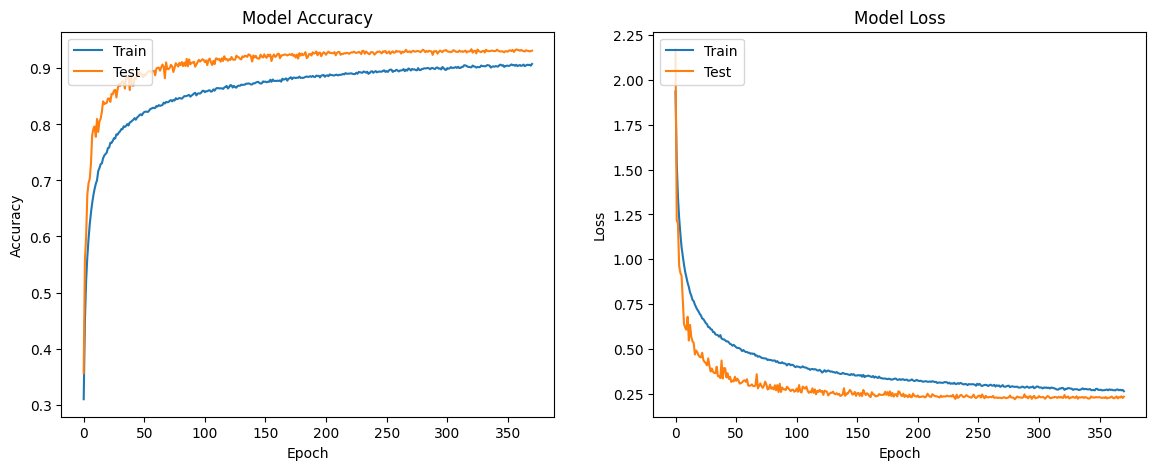

In [60]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [61]:
def random_horizontal_flip(image, p=0.5):
    """Randomly flip the image horizontally with a probability of p."""
    if random.random() < p:
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_rotation(image, max_angle=0):
    """Randomly rotate the image within a given angle range."""
    angle = random.uniform(-max_angle, max_angle)
    return image.rotate(angle)

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the ModelCheckpoint callback to save the model using the 'SavedModel' format
checkpoint = ModelCheckpoint('best_model-r9', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_format='tf')

# Initialize the generator with the custom augmentations
custom_data_generator = CustomImageDataGenerator(x_train, y_train, batch_size=256, augmentations=custom_augmentations)

# Train the model using the custom data generator
history = model.fit(custom_data_generator,
                    steps_per_epoch=len(x_train) // 256,
                    epochs=500, 
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint])  # Include both checkpoint and early stopping callbacks here

Epoch 1/500
195/195 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9137
Epoch 1: val_accuracy improved from -inf to 0.93480, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 122ms/step - loss: 0.2443 - accuracy: 0.9137 - val_loss: 0.2225 - val_accuracy: 0.9348
Epoch 2/500
195/195 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9155
Epoch 2: val_accuracy improved from 0.93480 to 0.93620, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 121ms/step - loss: 0.2440 - accuracy: 0.9155 - val_loss: 0.2227 - val_accuracy: 0.9362
Epoch 3/500
195/195 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9131
Epoch 3: val_accuracy did not improve from 0.93620
195/195 [==============================] - 21s 104ms/step - loss: 0.2440 - accuracy: 0.9131 - val_loss: 0.2209 - val_accuracy: 0.9346
Epoch 4/500
195/195 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9141
Epoch 4: val_accuracy did not improve from 0.93620
195/195 [==============================] - 20s 104ms/step - loss: 0.2419 - accuracy: 0.9141 - val_loss: 0.2230 - val_accuracy: 0.9356
Epoch 5/500
195/195 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.9146
Epoch 5: val_accuracy did not improve from 0.93620
195/195 [==============================] - 20s 104ms/step - loss: 0.2464 - accuracy: 0.9146 - val_loss: 0.2230 - val_accuracy: 0.9350
Epoch 6/500
195/195 

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 122ms/step - loss: 0.2428 - accuracy: 0.9151 - val_loss: 0.2207 - val_accuracy: 0.9365
Epoch 9/500
195/195 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9148
Epoch 9: val_accuracy improved from 0.93650 to 0.93740, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 122ms/step - loss: 0.2418 - accuracy: 0.9148 - val_loss: 0.2207 - val_accuracy: 0.9374
Epoch 10/500
195/195 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9144
Epoch 10: val_accuracy did not improve from 0.93740
195/195 [==============================] - 21s 104ms/step - loss: 0.2411 - accuracy: 0.9144 - val_loss: 0.2203 - val_accuracy: 0.9372
Epoch 11/500
195/195 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9159
Epoch 11: val_accuracy did not improve from 0.93740
195/195 [==============================] - 20s 104ms/step - loss: 0.2398 - accuracy: 0.9159 - val_loss: 0.2183 - val_accuracy: 0.9358
Epoch 12/500
195/195 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.9147
Epoch 12: val_accuracy did not improve from 0.93740
195/195 [==============================] - 21s 107ms/step - loss: 0.2456 - accuracy: 0.9147 - val_loss: 0.2186 - val_accuracy: 0.9362
Epoch 13/500
1

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 122ms/step - loss: 0.2414 - accuracy: 0.9159 - val_loss: 0.2224 - val_accuracy: 0.9376
Epoch 94/500
195/195 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9166
Epoch 94: val_accuracy did not improve from 0.93760
195/195 [==============================] - 21s 105ms/step - loss: 0.2367 - accuracy: 0.9166 - val_loss: 0.2243 - val_accuracy: 0.9352
Epoch 95/500
195/195 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9179
Epoch 95: val_accuracy did not improve from 0.93760
195/195 [==============================] - 20s 104ms/step - loss: 0.2366 - accuracy: 0.9179 - val_loss: 0.2185 - val_accuracy: 0.9370
Epoch 96/500
195/195 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9157
Epoch 96: val_accuracy improved from 0.93760 to 0.93810, saving model to best_model-r9


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 122ms/step - loss: 0.2390 - accuracy: 0.9157 - val_loss: 0.2206 - val_accuracy: 0.9381
Epoch 97/500
195/195 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9153
Epoch 97: val_accuracy did not improve from 0.93810
195/195 [==============================] - 21s 105ms/step - loss: 0.2369 - accuracy: 0.9153 - val_loss: 0.2223 - val_accuracy: 0.9366
Epoch 98/500
195/195 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9168
Epoch 98: val_accuracy did not improve from 0.93810
195/195 [==============================] - 20s 104ms/step - loss: 0.2360 - accuracy: 0.9168 - val_loss: 0.2226 - val_accuracy: 0.9358
Epoch 99/500
195/195 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9161
Epoch 99: val_accuracy did not improve from 0.93810
195/195 [==============================] - 20s 104ms/step - loss: 0.2403 - accuracy: 0.9161 - val_loss: 0.2228 - val_accuracy: 0.9369
Epoch 100/500


INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 122ms/step - loss: 0.2319 - accuracy: 0.9198 - val_loss: 0.2203 - val_accuracy: 0.9388
Epoch 230/500
195/195 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9189
Epoch 230: val_accuracy did not improve from 0.93880
195/195 [==============================] - 21s 104ms/step - loss: 0.2318 - accuracy: 0.9189 - val_loss: 0.2219 - val_accuracy: 0.9371
Epoch 231/500
195/195 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9208
Epoch 231: val_accuracy did not improve from 0.93880
195/195 [==============================] - 20s 104ms/step - loss: 0.2263 - accuracy: 0.9208 - val_loss: 0.2219 - val_accuracy: 0.9363
Epoch 232/500
195/195 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9207
Epoch 232: val_accuracy did not improve from 0.93880
195/195 [==============================] - 20s 104ms/step - loss: 0.2276 - accuracy: 0.9207 - val_loss: 0.2210 - val_accuracy: 0.9367
Epoch 23

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 121ms/step - loss: 0.2237 - accuracy: 0.9214 - val_loss: 0.2196 - val_accuracy: 0.9391
Epoch 387/500
195/195 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.9232
Epoch 387: val_accuracy did not improve from 0.93910
195/195 [==============================] - 21s 104ms/step - loss: 0.2195 - accuracy: 0.9232 - val_loss: 0.2199 - val_accuracy: 0.9373
Epoch 388/500
195/195 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9232
Epoch 388: val_accuracy did not improve from 0.93910
195/195 [==============================] - 20s 104ms/step - loss: 0.2213 - accuracy: 0.9232 - val_loss: 0.2215 - val_accuracy: 0.9365
Epoch 389/500
195/195 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9214
Epoch 389: val_accuracy did not improve from 0.93910
195/195 [==============================] - 20s 104ms/step - loss: 0.2252 - accuracy: 0.9214 - val_loss: 0.2233 - val_accuracy: 0.9361
Epoch 39

INFO:tensorflow:Assets written to: best_model-r9\assets


INFO:tensorflow:Assets written to: best_model-r9\assets


195/195 [==============================] - 24s 120ms/step - loss: 0.2216 - accuracy: 0.9242 - val_loss: 0.2194 - val_accuracy: 0.9397
Epoch 425/500
195/195 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9217
Epoch 425: val_accuracy did not improve from 0.93970
195/195 [==============================] - 21s 104ms/step - loss: 0.2236 - accuracy: 0.9217 - val_loss: 0.2211 - val_accuracy: 0.9378
Epoch 426/500
195/195 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9217
Epoch 426: val_accuracy did not improve from 0.93970
195/195 [==============================] - 20s 105ms/step - loss: 0.2252 - accuracy: 0.9217 - val_loss: 0.2229 - val_accuracy: 0.9367
Epoch 427/500
195/195 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9217
Epoch 427: val_accuracy did not improve from 0.93970
195/195 [==============================] - 20s 104ms/step - loss: 0.2228 - accuracy: 0.9217 - val_loss: 0.2226 - val_accuracy: 0.9371
Epoch 42

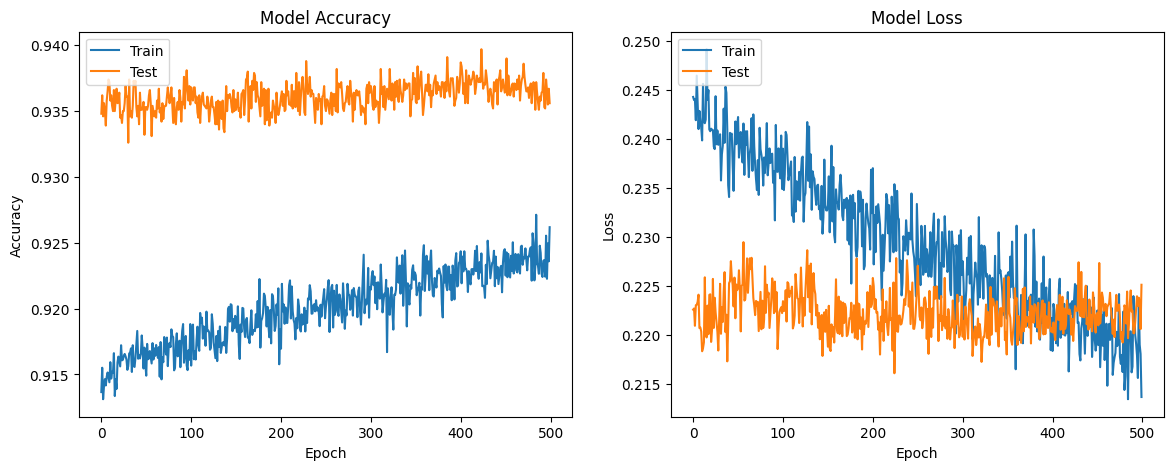

In [65]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
model.save('model-r9')